In [3]:
import pandas as pd

df = pd.read_csv("C:\\Users\\yuvra\\OneDrive\\Desktop\\Monsoon 2025\\iml_assignments\\A3\\ArtEmisProject\\data\\artemis_preprocessed_with_paths.csv")
print("Total samples:", len(df))
print(df["split"].value_counts())
print("Average caption length:", df["tokens_len"].mean())

Total samples: 430767
split
train    344581
test      64319
val       21867
Name: count, dtype: int64
Average caption length: 14.585683211573775


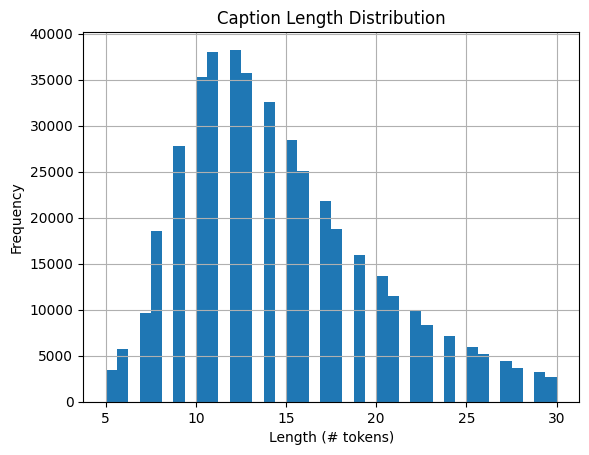

Mean length: 14.585683211573775
Median length: 14.0
95th percentile: 25.0


In [17]:
df["tokens_len"].hist(bins=40)
plt.title("Caption Length Distribution")
plt.xlabel("Length (# tokens)")
plt.ylabel("Frequency")
plt.show()

print("Mean length:", df["tokens_len"].mean())
print("Median length:", df["tokens_len"].median())
print("95th percentile:", df["tokens_len"].quantile(0.95))

In [9]:
import pickle

with open("C:\\Users\\yuvra\\OneDrive\\Desktop\\Monsoon 2025\\iml_assignments\\A3\\ArtEmisProject\\data\\vocab_simple.pkl", "rb") as f:
    vocab = pickle.load(f)

print("Vocab size:", len(vocab["itos"]))

Vocab size: 21298


In [11]:
from collections import Counter
import ast

all_words = []
for toks in df["tokens"]:
    toks_list = ast.literal_eval(toks)  # because tokens are stored as string repr
    all_words.extend(toks_list)

counts = Counter(all_words)
print(counts.most_common(20))

[('the', 588957), ('and', 228954), ('a', 210940), ('of', 184767), ('is', 156548), ('to', 115597), ('in', 109464), ('like', 107157), ('this', 101729), ('looks', 84468), ('i', 81240), ('it', 73487), ('are', 63148), ('me', 60741), ('on', 54544), ('with', 51554), ('look', 42946), ('very', 41530), ('makes', 40523), ('colors', 39360)]


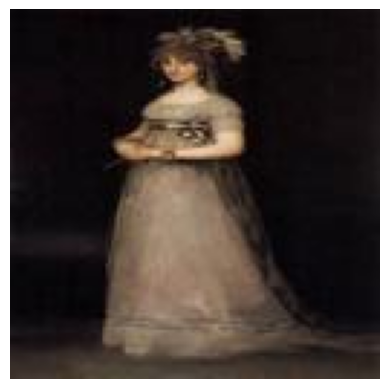

Caption: A woman of unusual beauty! I especially love the way she almost mystically emerges from the dark background.
Emotion: contentment
--------------------------------------------------


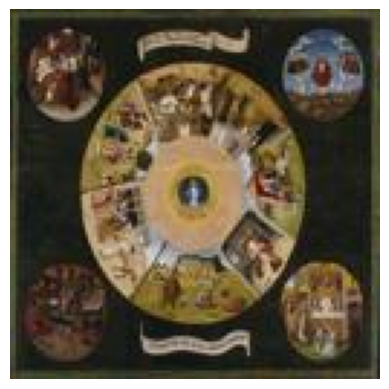

Caption: I like how there is a lot of paintings.
Emotion: something else
--------------------------------------------------


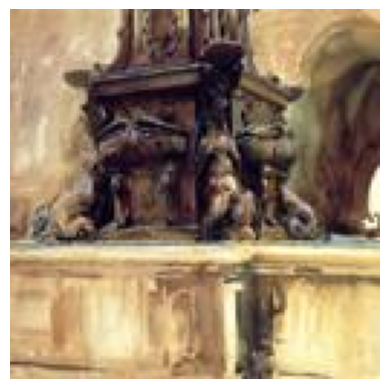

Caption: The post looks like it's surrounded by kittens morphing into gargoyles.
Emotion: disgust
--------------------------------------------------


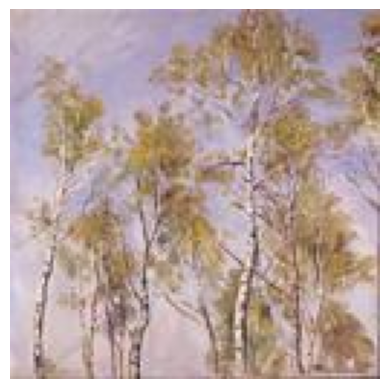

Caption: This painting makes me feel...a bit content as I look at what seems to be trees still maturing and developing quite beautifully
Emotion: contentment
--------------------------------------------------


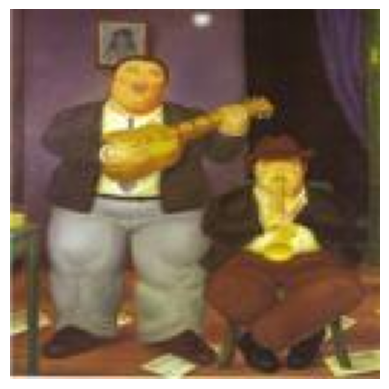

Caption: some good old men playing instruments on stage is a joy to see
Emotion: amusement
--------------------------------------------------


In [12]:
from PIL import Image
import matplotlib.pyplot as plt
import random

for _ in range(5):
    row = df.sample(1).iloc[0]
    img = Image.open(row["img_resized_path"])
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    print("Caption:", row["utterance"])
    print("Emotion:", row.get("emotion", "N/A"))
    print("-"*50)

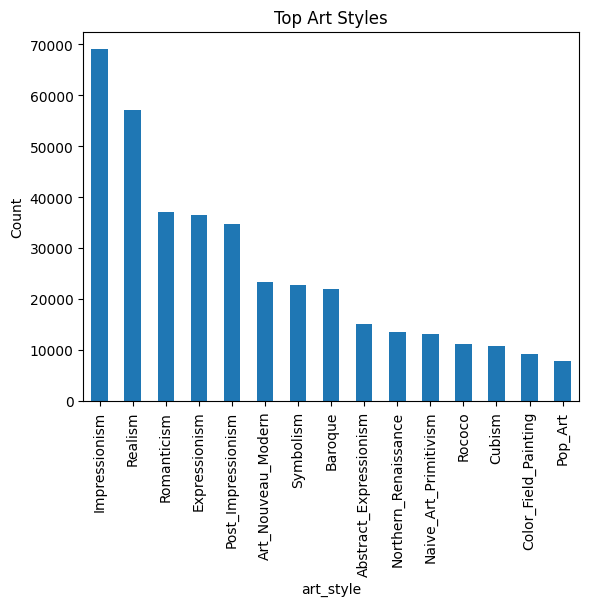

In [19]:
df["art_style"].value_counts().head(15).plot(kind="bar")
plt.title("Top Art Styles")
plt.ylabel("Count")
plt.show()

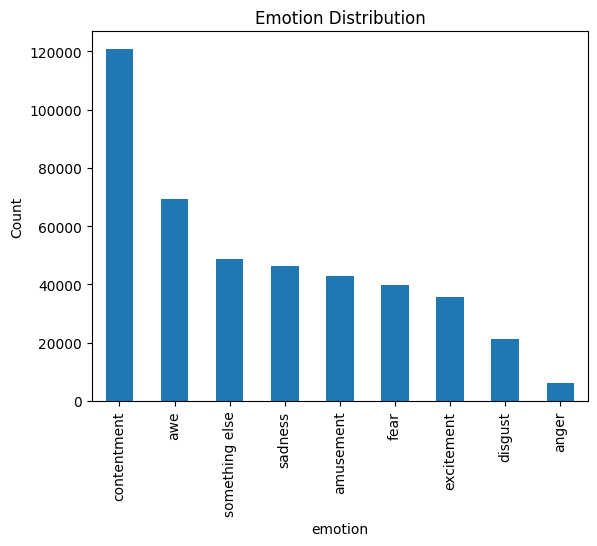

In [21]:
df["emotion"].value_counts().plot(kind="bar")
plt.title("Emotion Distribution")
plt.ylabel("Count")
plt.show()

In [49]:
#dataset and data loader

import sys
sys.path.append("C:\\Users\\yuvra\\OneDrive\\Desktop\\Monsoon 2025\\iml_assignments\\A3\\ArtEmisProject")

In [51]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

from src.dataset import ArtEmisCaptionDataset


In [52]:
import pandas as pd
from torchvision import transforms

csv_path = r"C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\data\artemis_preprocessed_with_paths.csv"
vocab_path = r"C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\data\vocab_simple.pkl"

image_transform = transforms.Compose([
    transforms.ToTensor(),  
])

train_df = pd.read_csv(csv_path)

train_csv = r"C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\data\train.csv"
val_csv   = r"C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\data\val.csv"
test_csv  = r"C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\data\test.csv"

train_df[train_df["split"] == "train"].to_csv(train_csv, index=False)
train_df[train_df["split"] == "val"].to_csv(val_csv, index=False)
train_df[train_df["split"] == "test"].to_csv(test_csv, index=False)


In [53]:
train_dataset = ArtEmisCaptionDataset(train_csv, vocab_path, transform=image_transform)
val_dataset   = ArtEmisCaptionDataset(val_csv, vocab_path, transform=image_transform)
test_dataset  = ArtEmisCaptionDataset(test_csv, vocab_path, transform=image_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

In [54]:
batch = next(iter(train_loader))
imgs, cap_in, cap_out, lengths = batch

print("Images:", imgs.shape)        # [B, 3, 128, 128]
print("Caption_in:", cap_in.shape)  # [B, max_len-1]
print("Caption_out:", cap_out.shape)
print("Lengths:", lengths[:10])

Images: torch.Size([32, 3, 128, 128])
Caption_in: torch.Size([32, 32])
Caption_out: torch.Size([32, 32])
Lengths: tensor([ 7, 10, 12, 10, 11, 12, 23, 11, 12, 13])


In [130]:
#tf-idf word embedding
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import numpy as np
import torch
import pickle

# 1. load train captions
import pandas as pd
csv_path = r"C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\data\artemis_preprocessed_with_paths.csv"
df = pd.read_csv(csv_path)
train_caps = df[df["split"] == "train"]["utterance"].astype(str).tolist()

# 2. TF-IDF over documents
vectorizer = TfidfVectorizer(
    lowercase=True,
    max_features=30000,    # safety cap
    min_df=5               # ignore very rare words
)
tfidf_matrix = vectorizer.fit_transform(train_caps)  # (num_docs, vocab_tfidf)

print("TF-IDF shape:", tfidf_matrix.shape)

# 3. SVD to get dense word vectors
n_components = 200
svd = TruncatedSVD(n_components=n_components, random_state=0)
word_matrix = svd.fit_transform(tfidf_matrix.T)  # (vocab_tfidf, 200)
print("Word matrix shape:", word_matrix.shape)

# 4. Map to your vocab order (itos)
vocab_tfidf = vectorizer.vocabulary_    # word -> col index in tfidf_matrix
embedding_dim = n_components

tfidf_embed = np.zeros((len(itos), embedding_dim), dtype=np.float32)

for idx, word in enumerate(itos):
    if word in vocab_tfidf:
        col = vocab_tfidf[word]
        tfidf_embed[idx] = word_matrix[col]
    else:
        # unseen in TF-IDF training → leave as zeros
        tfidf_embed[idx] = np.zeros(embedding_dim, dtype=np.float32)

# 5. create embedding layer
tfidf_embedding_layer = torch.nn.Embedding.from_pretrained(
    torch.tensor(tfidf_embed),
    freeze=True  # or False if you want it trainable
)

print("Final TF-IDF embedding layer:", tfidf_embedding_layer.weight.shape)


TF-IDF shape: (344581, 14601)
Word matrix shape: (14601, 200)
Final TF-IDF embedding layer: torch.Size([21298, 200])


In [132]:
#sanity check tf idf

print("Embedding matrix shape:", tfidf_embed_reduced.shape)
print("dtype:", tfidf_embed_reduced.dtype)
import numpy as np

print("NaNs:", np.isnan(tfidf_embed_reduced).sum())
print("Infs:", np.isinf(tfidf_embed_reduced).sum())

words_to_test = ["the", "and", "a", "man", "woman", "color"]

for w in words_to_test:
    if w in stoi:
        idx = stoi[w]
        vec = tfidf_embed_reduced[idx]
        print(w, np.linalg.norm(vec))
    else:
        print(w, "not in vocab")
from numpy.linalg import norm

def cos_sim(a, b):
    return np.dot(a, b) / (norm(a) * norm(b) + 1e-9)

def word_sim(w1, w2):
    if w1 not in stoi or w2 not in stoi:
        return None
    return cos_sim(
        tfidf_embed_reduced[stoi[w1]],
        tfidf_embed_reduced[stoi[w2]],
    )

pairs = [
    ("man", "woman"),
    ("happy", "joy"),
    ("dark", "light"),
    ("painting", "art"),
    ("blue", "red"),
]

for a, b in pairs:
    print(f"{a}–{b} similarity:", word_sim(a, b))
norms = np.linalg.norm(tfidf_embed_reduced, axis=1)
print("Avg norm:", norms.mean())
print("Min norm:", norms.min())
print("Max norm:", norms.max())



Embedding matrix shape: (21298, 200)
dtype: float32
NaNs: 0
Infs: 0
the 0.11877179
and 0.13578026
a 0.11478142
man 0.11930586
woman 0.1339103
color 0.12498246
man–woman similarity: -0.02294560957129955
happy–joy similarity: 0.010339036951970127
dark–light similarity: -0.05889636472160208
painting–art similarity: -0.046219343384260994
blue–red similarity: 0.03501291285202929
Avg norm: 0.07594825
Min norm: 4.316767e-07
Max norm: 0.14986144


In [12]:
# word 2 vec
import pandas as pd
import pickle
import ast

train_csv = r"C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\data\train.csv"
vocab_path = r"C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\data\vocab_simple.pkl"

df_train = pd.read_csv(train_csv)

with open(vocab_path, "rb") as f:
    vocab = pickle.load(f)

stoi = vocab["stoi"]
itos = vocab["itos"]
vocab_size = len(itos)
print("Vocab size:", vocab_size)


Vocab size: 21298


In [13]:
# tokens are stored as string representation of list → convert back
sentences = [
    ast.literal_eval(toks) 
    for toks in df_train["tokens"].astype(str).tolist()
]

print("Number of training captions:", len(sentences))
print("Example:", sentences[0][:10])


Number of training captions: 344581
Example: ['too', 'much', 'yellow', 'and', 'red', 'and', 'poorly', 'blended,', 'and', 'the']


In [20]:
from gensim.models import Word2Vec

w2v_dim = 200  # embedding size (can match TF-IDF dim)

w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=w2v_dim,
    window=5,        # context window size
    min_count=5,     # ignore words with freq < 5
    workers=4,       # adjust to #CPU cores
    sg=1,            # 1 = skip-gram, 0 = CBOW (skip-gram is usually better)
    epochs=5         # you can bump this to 10 if training is fast
)

print("Word2Vec vocab size:", len(w2v_model.wv))

w2v_model.save(
    r"C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\data\w2v_artemis.model"
)

Word2Vec vocab size: 21294


In [22]:
import numpy as np

w2v_embed_matrix = np.zeros((vocab_size, w2v_dim), dtype=np.float32)

found = 0
for idx, word in enumerate(itos):
    if word in w2v_model.wv:
        w2v_embed_matrix[idx] = w2v_model.wv[word]
        found += 1
    else:
        # random small vector for OOV words
        w2v_embed_matrix[idx] = np.random.normal(
            scale=0.01, size=(w2v_dim,)
        ).astype(np.float32)

print("Word2Vec embedding matrix shape:", w2v_embed_matrix.shape)
print("Words found in Word2Vec vocab:", found, "/", vocab_size)


Word2Vec embedding matrix shape: (21298, 200)
Words found in Word2Vec vocab: 21294 / 21298


In [24]:
import torch

w2v_weights = torch.tensor(w2v_embed_matrix, dtype=torch.float32)

w2v_embedding_layer = torch.nn.Embedding.from_pretrained(
    w2v_weights,
    freeze=True   # non-trainable, as required
)


In [26]:
#Sanity check
from numpy.linalg import norm

def cos_sim(a, b):
    return float(np.dot(a, b) / (norm(a) * norm(b) + 1e-9))

def w2v_word_sim(w1, w2):
    if w1 not in stoi or w2 not in stoi:
        return None
    return cos_sim(
        w2v_embed_matrix[stoi[w1]],
        w2v_embed_matrix[stoi[w2]],
    )

print("man–woman:", w2v_word_sim("man", "woman"))
print("happy–joy:", w2v_word_sim("happy", "joy"))
print("blue–red:", w2v_word_sim("blue", "red"))


man–woman: 0.512386288945509
happy–joy: 0.480425531876665
blue–red: 0.5181953996704429


In [28]:
#glove embedding
import numpy as np

glove_path = r"C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\data\glove.6B.100d.txt"
glove_dim = 100

glove_vectors = {}

with open(glove_path, "r", encoding="utf8") as f:
    for line in f:
        parts = line.rstrip().split(" ")
        word = parts[0]
        vec = np.asarray(parts[1:], dtype=np.float32)
        if vec.shape[0] == glove_dim:
            glove_vectors[word] = vec

print("Loaded GloVe vectors:", len(glove_vectors))


Loaded GloVe vectors: 400000


In [29]:
vocab_size = len(itos)
glove_embed_matrix = np.zeros((vocab_size, glove_dim), dtype=np.float32)

found = 0
for idx, word in enumerate(itos):
    if word in glove_vectors:
        glove_embed_matrix[idx] = glove_vectors[word]
        found += 1
    else:
        # small random vector for OOV words
        glove_embed_matrix[idx] = np.random.normal(
            scale=0.01, size=(glove_dim,)
        ).astype(np.float32)

print("GloVe embedding matrix shape:", glove_embed_matrix.shape)
print("Words found in GloVe:", found, "/", vocab_size, "({:.2f}%)".format(100*found/vocab_size))


GloVe embedding matrix shape: (21298, 100)
Words found in GloVe: 13032 / 21298 (61.19%)


In [30]:
import torch

glove_weights = torch.tensor(glove_embed_matrix, dtype=torch.float32)

glove_embedding_layer = torch.nn.Embedding.from_pretrained(
    glove_weights,
    freeze=True  # keep non-trainable as per assignment
)

In [31]:
#sanity check
from numpy.linalg import norm

def cos_sim(a, b):
    return float(np.dot(a, b) / (norm(a) * norm(b) + 1e-9))

def glove_sim(w1, w2):
    if w1 not in stoi or w2 not in stoi:
        return None
    return cos_sim(
        glove_embed_matrix[stoi[w1]],
        glove_embed_matrix[stoi[w2]],
    )

print("man–woman:", glove_sim("man", "woman"))
print("happy–joy:", glove_sim("happy", "joy"))
print("blue–red:", glove_sim("blue", "red"))


man–woman: 0.8323493892754168
happy–joy: 0.5188851443285378
blue–red: 0.8435066052491488


In [75]:
#Model training

#CNN + Lstm
import torch.optim as optim


import sys
sys.path.append(r"C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject")

from src.models_cnn_lstm import CNNLSTMCaptioner
import pickle
import torch
import torch.nn as nn
import torch.optim as optim

vocab_path = r"C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\data\vocab_simple.pkl"

with open(vocab_path, "rb") as f:
    vocab = pickle.load(f)

stoi = vocab["stoi"]
itos = vocab["itos"]
special = vocab["special_tokens"]
pad_idx = special["<pad>"]
start_idx = special["<start>"]
end_idx = special["<end>"]
vocab_size = len(itos)


In [134]:
hidden_dim = 256

model_tfidf = CNNLSTMCaptioner(
    embedding_layer=tfidf_embedding_layer,  
    hidden_dim=hidden_dim,
    vocab_size=vocab_size,
    pad_idx=pad_idx,
).to("cuda" if torch.cuda.is_available() else "cpu")


In [135]:
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
optimizer = optim.Adam(model_tfidf.parameters(), lr=1e-3)

In [138]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_tfidf.to(device)

batch = next(iter(train_loader))
imgs, cap_in, cap_out, lengths = batch

imgs = imgs.to(device)
cap_in = cap_in.to(device)
cap_out = cap_out.to(device)

logits = model_tfidf(imgs, cap_in)      # [B, T, vocab_size]
print("Logits shape:", logits.shape)

criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

B, T, V = logits.shape

loss = criterion(
    logits.view(B*T, V),    # [B*T, vocab_size]
    cap_out.view(B*T)       # [B*T]
)

print("Loss:", loss.item())


Logits shape: torch.Size([32, 32, 21298])
Loss: 9.971205711364746


In [140]:
#check cuda
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else None)

import sys
print(sys.executable)



Torch version: 2.5.1+cu121
CUDA available: True
CUDA version: 12.1
GPU name: NVIDIA GeForce RTX 4050 Laptop GPU
C:\Users\yuvra\anaconda3\python.exe


In [82]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    n_tokens = 0

    for imgs, cap_in, cap_out, lengths in dataloader:
        imgs = imgs.to(device)
        cap_in = cap_in.to(device)
        cap_out = cap_out.to(device)

        optimizer.zero_grad()

        # Forward
        logits = model(imgs, cap_in)  # [B, T, V]
        B, T, V = logits.shape

        loss = criterion(
            logits.view(B*T, V),
            cap_out.view(B*T)
        )
        loss.backward()
        optimizer.step()

        # Track loss weighted by number of non-pad tokens
        with torch.no_grad():
            # count non-pad targets
            mask = (cap_out != pad_idx)
            n_nonpad = mask.sum().item()
            running_loss += loss.item() * n_nonpad
            n_tokens += n_nonpad

    return running_loss / max(n_tokens, 1)


def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    n_tokens = 0

    with torch.no_grad():
        for imgs, cap_in, cap_out, lengths in dataloader:
            imgs = imgs.to(device)
            cap_in = cap_in.to(device)
            cap_out = cap_out.to(device)

            logits = model(imgs, cap_in)  # [B, T, V]
            B, T, V = logits.shape

            loss = criterion(
                logits.view(B*T, V),
                cap_out.view(B*T)
            )

            # count non-pad
            mask = (cap_out != pad_idx)
            n_nonpad = mask.sum().item()
            running_loss += loss.item() * n_nonpad
            n_tokens += n_nonpad

    return running_loss / max(n_tokens, 1)


In [152]:
num_epochs = 20        # upper bound
patience = 3           # stop if no improvement for 3 epochs
best_val_loss = float("inf")
epochs_no_improve = 0

best_model_path_tfidf = os.path.join(models_dir, "tfidf_svd_cnnlstm_best_new.pt")

for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch(
        model_tfidf,
        train_loader,
        optimizer,
        criterion,
        device,
    )
    val_loss = evaluate(
        model_tfidf,
        val_loader,
        criterion,
        device,
    )

    print(f"[TF-IDF+SVD] Epoch {epoch}/{num_epochs} | train loss: {train_loss:.4f} | val loss: {val_loss:.4f}")

    if val_loss < best_val_loss - 1e-4:   # small delta to avoid noise
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model_tfidf.state_dict(), best_model_path_tfidf)
        print("Saved new best TF-IDF model")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s)")

        if epochs_no_improve >= patience:
            print("Early stopping triggered for TF-IDF")
            break

print("Best val loss (TF-IDF):", best_val_loss)
print("Best model saved at:", best_model_path_tfidf)


[TF-IDF+SVD] Epoch 1/20 | train loss: 3.9951 | val loss: 4.0877
Saved new best TF-IDF model
[TF-IDF+SVD] Epoch 2/20 | train loss: 3.9162 | val loss: 4.0680
Saved new best TF-IDF model
[TF-IDF+SVD] Epoch 3/20 | train loss: 3.8609 | val loss: 4.0607
Saved new best TF-IDF model
[TF-IDF+SVD] Epoch 4/20 | train loss: 3.8186 | val loss: 4.0576
Saved new best TF-IDF model
[TF-IDF+SVD] Epoch 5/20 | train loss: 3.7848 | val loss: 4.0641
No improvement for 1 epoch(s)
[TF-IDF+SVD] Epoch 6/20 | train loss: 3.7567 | val loss: 4.0601
No improvement for 2 epoch(s)
[TF-IDF+SVD] Epoch 7/20 | train loss: 3.7332 | val loss: 4.0681
No improvement for 3 epoch(s)
Early stopping triggered for TF-IDF
Best val loss (TF-IDF): 4.057600400385614
Best model saved at: C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\models\tfidf_svd_cnnlstm_best_new.pt


In [96]:
import os

models_dir = r"C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\models"
os.makedirs(models_dir, exist_ok=True)

# --- build the model with Word2Vec embedding ---
model_w2v = CNNLSTMCaptioner(
    embedding_layer=w2v_embedding_layer,
    hidden_dim=hidden_dim,
    vocab_size=vocab_size,
    pad_idx=pad_idx,
).to(device)

criterion_w2v = nn.CrossEntropyLoss(ignore_index=pad_idx)
optimizer_w2v = optim.Adam(model_w2v.parameters(), lr=1e-3)

num_epochs = 5  # or fewer if you want
best_val_loss = float("inf")
best_model_path_w2v = os.path.join(models_dir, "w2v_cnnlstm_best.pt")

for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch(model_w2v, train_loader, optimizer_w2v, criterion_w2v, device)
    val_loss = evaluate(model_w2v, val_loader, criterion_w2v, device)

    print(f"[Word2Vec] Epoch {epoch}/{num_epochs} | train loss: {train_loss:.4f} | val loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_w2v.state_dict(), best_model_path_w2v)
        print("Saved new Word2Vec model")


[Word2Vec] Epoch 1/5 | train loss: 4.3570 | val loss: 4.0039
Saved new Word2Vec model
[Word2Vec] Epoch 2/5 | train loss: 3.8652 | val loss: 3.8555
Saved new Word2Vec model
[Word2Vec] Epoch 3/5 | train loss: 3.7189 | val loss: 3.8046
Saved new Word2Vec model
[Word2Vec] Epoch 4/5 | train loss: 3.6346 | val loss: 3.7848
Saved new Word2Vec model
[Word2Vec] Epoch 5/5 | train loss: 3.5759 | val loss: 3.7820
Saved new Word2Vec model


In [97]:
# --- build the model with GloVe embedding ---
model_glove = CNNLSTMCaptioner(
    embedding_layer=glove_embedding_layer,
    hidden_dim=hidden_dim,
    vocab_size=vocab_size,
    pad_idx=pad_idx,
).to(device)

criterion_glove = nn.CrossEntropyLoss(ignore_index=pad_idx)
optimizer_glove = optim.Adam(model_glove.parameters(), lr=1e-3)

num_epochs = 5  # or fewer
best_val_loss = float("inf")
best_model_path_glove = os.path.join(models_dir, "glove_cnnlstm_best.pt")

for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch(model_glove, train_loader, optimizer_glove, criterion_glove, device)
    val_loss = evaluate(model_glove, val_loader, criterion_glove, device)

    print(f"[GloVe] Epoch {epoch}/{num_epochs} | train loss: {train_loss:.4f} | val loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_glove.state_dict(), best_model_path_glove)
        print("Saved new GloVe model")

[GloVe] Epoch 1/5 | train loss: 4.4829 | val loss: 4.1074
Saved new GloVe model
[GloVe] Epoch 2/5 | train loss: 3.9851 | val loss: 3.9670
Saved new GloVe model
[GloVe] Epoch 3/5 | train loss: 3.8417 | val loss: 3.9176
Saved new GloVe model
[GloVe] Epoch 4/5 | train loss: 3.7588 | val loss: 3.8995
Saved new GloVe model
[GloVe] Epoch 5/5 | train loss: 3.7017 | val loss: 3.8926
Saved new GloVe model


In [177]:
#New scratch w2v and glove models
from src.models_cnn_lstm import CNNLSTMCaptioner
import torch.nn as nn
import torch.optim as optim

hidden_dim = 256

model_w2v = CNNLSTMCaptioner(
    embedding_layer=w2v_embedding_layer,
    hidden_dim=hidden_dim,
    vocab_size=vocab_size,
    pad_idx=pad_idx,
).to(device)

criterion_w2v = nn.CrossEntropyLoss(ignore_index=pad_idx)
optimizer_w2v = optim.Adam(model_w2v.parameters(), lr=1e-3)

num_epochs = 20
patience = 3
best_val_loss = float("inf")
epochs_no_improve = 0
best_model_path_w2v = os.path.join(models_dir, "w2v_cnnlstm_best_new.pt")

for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch(model_w2v, train_loader, optimizer_w2v, criterion_w2v, device)
    val_loss   = evaluate(model_w2v,   val_loader, criterion_w2v, device)

    print(f"[W2V] Epoch {epoch}/{num_epochs} | train loss: {train_loss:.4f} | val loss: {val_loss:.4f}")

    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model_w2v.state_dict(), best_model_path_w2v)
        print("Saved new best W2V model")
    else:
        epochs_no_improve += 1
        print("No improvement for", epochs_no_improve, "epoch(s)")
        if epochs_no_improve >= patience:
            print("Early stopping triggered for W2V")
            break


[W2V] Epoch 1/20 | train loss: 4.3571 | val loss: 4.0054
Saved new best W2V model
[W2V] Epoch 2/20 | train loss: 3.8717 | val loss: 3.8623
Saved new best W2V model
[W2V] Epoch 3/20 | train loss: 3.7248 | val loss: 3.8087
Saved new best W2V model
[W2V] Epoch 4/20 | train loss: 3.6395 | val loss: 3.7888
Saved new best W2V model
[W2V] Epoch 5/20 | train loss: 3.5799 | val loss: 3.7769
Saved new best W2V model
[W2V] Epoch 6/20 | train loss: 3.5348 | val loss: 3.7814
No improvement for 1 epoch(s)
[W2V] Epoch 7/20 | train loss: 3.4989 | val loss: 3.7856
No improvement for 2 epoch(s)
[W2V] Epoch 8/20 | train loss: 3.4689 | val loss: 3.7904
No improvement for 3 epoch(s)
Early stopping triggered for W2V


In [178]:
# New scratch GloVe model
from src.models_cnn_lstm import CNNLSTMCaptioner
import torch.nn as nn
import torch.optim as optim

hidden_dim = 256

model_glove = CNNLSTMCaptioner(
    embedding_layer=glove_embedding_layer,
    hidden_dim=hidden_dim,
    vocab_size=vocab_size,
    pad_idx=pad_idx,
).to(device)

criterion_glove = nn.CrossEntropyLoss(ignore_index=pad_idx)
optimizer_glove = optim.Adam(model_glove.parameters(), lr=1e-3)

num_epochs = 20
patience = 3
best_val_glove = float("inf")
epochs_no_improve_glove = 0
best_model_path_glove = os.path.join(models_dir, "glove_cnnlstm_best_new.pt")
 
for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch(model_glove, train_loader, optimizer_glove, criterion_glove, device)
    val_loss   = evaluate(model_glove,   val_loader, criterion_glove, device)

    print(f"[GloVe] Epoch {epoch}/{num_epochs} | train loss: {train_loss:.4f} | val loss: {val_loss:.4f}")

    if val_loss < best_val_glove - 1e-4:
        best_val_glove = val_loss
        epochs_no_improve_glove = 0
        torch.save(model_glove.state_dict(), best_model_path_glove)
        print("Saved new best GloVe model")
    else:
        epochs_no_improve_glove += 1
        print("No improvement for", epochs_no_improve_glove, "epoch(s)")
        if epochs_no_improve_glove >= patience:
            print("Early stopping triggered for GloVe")
            break

print("Best val loss (GloVe):", best_val_glove)
print("Best model saved at:", best_model_path_glove)

[GloVe] Epoch 1/20 | train loss: 4.4791 | val loss: 4.1151
Saved new best GloVe model
[GloVe] Epoch 2/20 | train loss: 3.9933 | val loss: 3.9781
Saved new best GloVe model
[GloVe] Epoch 3/20 | train loss: 3.8496 | val loss: 3.9252
Saved new best GloVe model
[GloVe] Epoch 4/20 | train loss: 3.7678 | val loss: 3.9069
Saved new best GloVe model
[GloVe] Epoch 5/20 | train loss: 3.7112 | val loss: 3.8968
Saved new best GloVe model
[GloVe] Epoch 6/20 | train loss: 3.6680 | val loss: 3.8969
No improvement for 1 epoch(s)
[GloVe] Epoch 7/20 | train loss: 3.6342 | val loss: 3.8981
No improvement for 2 epoch(s)
[GloVe] Epoch 8/20 | train loss: 3.6062 | val loss: 3.9034
No improvement for 3 epoch(s)
Early stopping triggered for GloVe
Best val loss (GloVe): 3.8968143653999103
Best model saved at: C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\models\glove_cnnlstm_best_new.pt


In [100]:
# Loading the models
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

models_dir = r"C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\models"

vocab_path = r"C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\data\vocab_simple.pkl"
with open(vocab_path, "rb") as f:
    vocab = pickle.load(f)

stoi = vocab["stoi"]
itos = vocab["itos"]
special = vocab["special_tokens"]
pad_idx   = special["<pad>"]
start_idx = special["<start>"]
end_idx   = special["<end>"]
vocab_size = len(itos)

from src.models_cnn_lstm import CNNLSTMCaptioner

hidden_dim = 256


Device: cuda


In [181]:
# TF-IDF
model_tfidf = CNNLSTMCaptioner(
    embedding_layer=tfidf_embedding_layer,
    hidden_dim=hidden_dim,
    vocab_size=vocab_size,
    pad_idx=pad_idx,
).to(device)

tfidf_best_path = os.path.join(models_dir, "tfidf_svd_cnnlstm_best_new.pt")
model_tfidf.load_state_dict(torch.load(tfidf_best_path, map_location=device))

# Word2Vec
model_w2v = CNNLSTMCaptioner(
    embedding_layer=w2v_embedding_layer,
    hidden_dim=hidden_dim,
    vocab_size=vocab_size,
    pad_idx=pad_idx,
).to(device)

w2v_best_path = os.path.join(models_dir, "w2v_cnnlstm_best_new.pt")
model_w2v.load_state_dict(torch.load(w2v_best_path, map_location=device))

# GloVe
model_glove = CNNLSTMCaptioner(
    embedding_layer=glove_embedding_layer,
    hidden_dim=hidden_dim,
    vocab_size=vocab_size,
    pad_idx=pad_idx,
).to(device)

glove_best_path = os.path.join(models_dir, "glove_cnnlstm_best_new.pt")
model_glove.load_state_dict(torch.load(glove_best_path, map_location=device))


C:\Users\yuvra\AppData\Local\Temp\ipykernel_27544\3647514563.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_tfidf.load_state_dict(torch.load(tfidf_best_path, map

<All keys matched successfully>

In [183]:
def generate_caption(model, img_tensor, itos, start_idx, end_idx, max_len=30, device="cpu"):
    """
    model: CNNLSTMCaptioner
    img_tensor: [3, 128, 128] (from dataset)
    """
    model.eval()
    img_tensor = img_tensor.unsqueeze(0).to(device)  # [1, 3, 128, 128]

    with torch.no_grad():
        # 1) Encode image
        img_feat = model.cnn_encoder(img_tensor)  # [1, img_feat_dim]

        # 2) Init hidden state from image
        h = torch.tanh(model.img_to_h(img_feat))  # [1, hidden_dim]
        c = torch.tanh(model.img_to_c(img_feat))  # [1, hidden_dim]
        h = h.unsqueeze(0)  # [1, 1, hidden_dim]
        c = c.unsqueeze(0)  # [1, 1, hidden_dim]

        # 3) Start with <start> token
        cur = torch.tensor([[start_idx]], dtype=torch.long, device=device)  # [1, 1]

        generated_ids = []

        for _ in range(max_len):
            # cur: [1, 1] → emb: [1, 1, D]
            emb = model.embedding(cur)            # [1, 1, embed_dim]

            # one LSTM step
            out, (h, c) = model.lstm(emb, (h, c)) # out: [1, 1, hidden_dim]

            # logits → next token
            logits = model.fc_out(out.squeeze(1)) # [1, vocab_size]
            next_id = logits.argmax(dim=-1)       # [1]

            tid = next_id.item()
            if tid == end_idx:
                break

            generated_ids.append(tid)

            # feed next token → must be shape [1, 1]
            cur = next_id.unsqueeze(0)            # [1] -> [1, 1]

    # Decode ids to words
    words = []
    for tid in generated_ids:
        w = itos[tid]
        if w in ["<pad>", "<start>", "<end>"]:
            continue
        words.append(w)

    return " ".join(words)


Sample 1/7 | val index: 1571


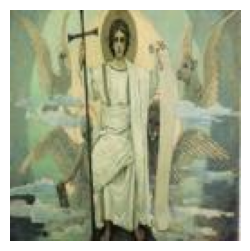

GT:     the way the person in the middle is standing with the crucifix gives a sense of awe at their power and majestic flair.
TF-IDF: the man looks like he is about to be beheaded.
W2V:    the woman is wearing a white dress and her head is so large
GloVe:  the woman is wearing a black dress and looks like she is in a hurry
Sample 2/7 | val index: 7752


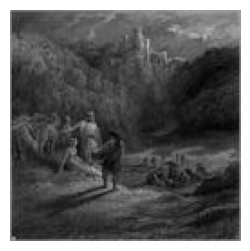

GT:     it looks like peasants toiling in the field below the king and castle
TF-IDF: the dark colors and the way the people are huddled together gives me a feeling of fear.
W2V:    the dark colors and the people in the painting make me feel sad
GloVe:  the dark colors and the dark shadows make this a scary scene
Sample 3/7 | val index: 6881


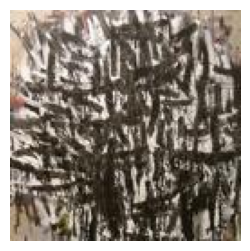

GT:     to me this looks like a blend of modern art and graffiti.
TF-IDF: the black and white is very well done and the colors are very vibrant.
W2V:    the dark colors and the people in the painting make me feel sad
GloVe:  the black and white colors are very interesting and i like the contrast of the black and white
Sample 4/7 | val index: 5328


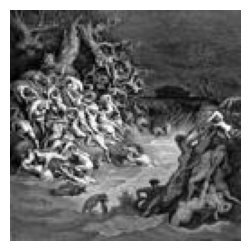

GT:     there is not even the comfort of color in this realm of terror where every person's body is contorted in fear and agony
TF-IDF: the dark colors and the way the people are looking at the man in the painting is scary
W2V:    the dark colors and the people in the painting make me feel sad
GloVe:  the dark colors and the dark shadows make this a scary scene
Sample 5/7 | val index: 18429


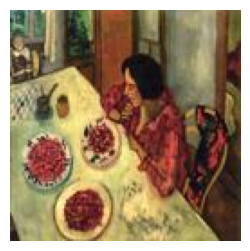

GT:     i feel hungry looking at the plates of food
TF-IDF: the colors are very vibrant and the flowers are very pretty.
W2V:    the woman is wearing a white dress and her head is <unk>
GloVe:  the woman is holding her baby as if she is being forced to be <unk>
Sample 6/7 | val index: 18995


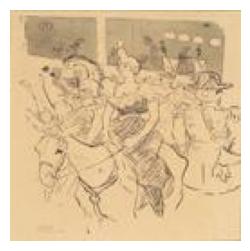

GT:     almost like a newspaper print color the setting is to look at
TF-IDF: the man looks like he is trying to force a
W2V:    the painting is very simple and lacks any color
GloVe:  the man looks like he is in a battle
Sample 7/7 | val index: 16657


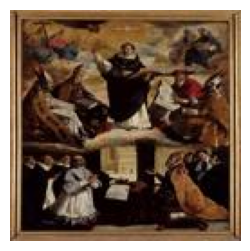

GT:     the painting and colors going from dark at the bottom to light at the top remind me of enlightenment.
TF-IDF: the man in the center looks like he is trying to lure the man in the middle of the painting.
W2V:    the man in the painting looks like he is in pain and the man is holding his head on his head.
GloVe:  the man looks like he is in a battle


In [203]:
import matplotlib.pyplot as plt
import random

def decode_words(token_ids, itos):
    words = []
    for t in token_ids:
        w = itos[int(t)]
        if w in ["<pad>", "<start>", "<end>", "<unk>"]:
            continue
        words.append(w)
    return words

for i in range(7):
    idx = random.randint(0, len(val_dataset) - 1)
    img, cap_in, cap_out, length = val_dataset[idx]

    print("=" * 80)
    print(f"Sample {i+1}/7 | val index: {idx}")

    plt.figure(figsize=(3, 3))
    plt.imshow(img.permute(1, 2, 0))
    plt.axis("off")
    plt.show()

    # ground-truth caption
    gt_tokens = cap_out[:length].tolist()
    gt_words = decode_words(gt_tokens, itos)
    print("GT:    ", " ".join(gt_words))

    # model captions
    tfidf_cap = generate_caption(model_tfidf, img, itos, start_idx, end_idx, device=device)
    w2v_cap   = generate_caption(model_w2v,   img, itos, start_idx, end_idx, device=device)
    glove_cap = generate_caption(model_glove, img, itos, start_idx, end_idx, device=device)

    print("TF-IDF:", tfidf_cap)
    print("W2V:   ", w2v_cap)
    print("GloVe: ", glove_cap)


In [190]:
# evaluation

!pip install nltk
import nltk
nltk.download('punkt')

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
smooth = SmoothingFunction().method1

def evaluate_bleu(model, dataset, itos, start_idx, end_idx, device, num_samples=300):
    model.eval()
    scores = []
    n = min(num_samples, len(dataset))

    for i in range(n):
        img, cap_in, cap_out, length = dataset[i]

        gt_tokens = cap_out[:length].tolist()
        gt_words = decode_words(gt_tokens, itos)

        pred_sentence = generate_caption(
            model,
            img,
            itos,
            start_idx=start_idx,
            end_idx=end_idx,
            max_len=30,
            device=device,
        )
        pred_words = pred_sentence.split()

        if len(gt_words) == 0 or len(pred_words) == 0:
            continue

        bleu = sentence_bleu(
            [gt_words],
            pred_words,
            smoothing_function=smooth,
            weights=(0.25, 0.25, 0.25, 0.25),  # BLEU-4
        )
        scores.append(bleu)

    return sum(scores) / max(len(scores), 1)



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yuvra\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [193]:
tfidf_bleu = evaluate_bleu(model_tfidf, val_dataset, itos, start_idx, end_idx, device, num_samples=300)
w2v_bleu   = evaluate_bleu(model_w2v,       val_dataset, itos, start_idx, end_idx, device, num_samples=300)
glove_bleu = evaluate_bleu(model_glove,     val_dataset, itos, start_idx, end_idx, device, num_samples=300)

print("TF-IDF+SVD BLEU-4:", tfidf_bleu)
print("Word2Vec BLEU-4:  ", w2v_bleu)
print("GloVe BLEU-4:     ", glove_bleu)


TF-IDF+SVD BLEU-4: 0.02917766617723179
Word2Vec BLEU-4:   0.025162337115231484
GloVe BLEU-4:      0.027037488074460363


In [1]:
# Model 2 ViT

!pip install transformers accelerate timm


   ---------------------------------------- 0.0/12.0 MB ? eta -:--:--
   ------ --------------------------------- 2.1/12.0 MB 10.7 MB/s eta 0:00:01
   ---------------------- ----------------- 6.8/12.0 MB 16.8 MB/s eta 0:00:01
   ---------------------------------------  11.8/12.0 MB 18.9 MB/s eta 0:00:01
   ---------------------------------------- 12.0/12.0 MB 17.5 MB/s  0:00:00
   ---------------------------------------- 0.0/566.1 kB ? eta -:--:--
   ---------------------------------------- 566.1/566.1 kB 9.8 MB/s  0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 2.7/2.7 MB 21.9 MB/s  0:00:00
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---------------------------------------- 2.5/2.5 MB 18.1 MB/s  0:00:00

   ------ --------------------------------- 1/6 [huggingface-hub]
   ------ --------------------------------- 1/6 [huggingface-hub]
   ------ --------------------------------- 1/6 [hug


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
from transformers import BlipProcessor, BlipForConditionalGeneration
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

model_name = "Salesforce/blip-image-captioning-base"

processor = BlipProcessor.from_pretrained(model_name)
model = BlipForConditionalGeneration.from_pretrained(model_name).to(device)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /Salesforce/blip-image-captioning-base/resolve/main/preprocessor_config.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000001F594BA6A50>: Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: 40591477-33e5-4f36-bf07-f77975e65ccc)')' thrown while requesting HEAD https://huggingface.co/Salesforce/blip-image-captioning-base/resolve/main/preprocessor_config.json
Retrying in 1s [Retry 1/5].


Using sample: C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\resized\wikiart_128\Post_Impressionism\vincent-van-gogh_portrait-of-madame-ginoux-l-arlesienne-1890.jpg


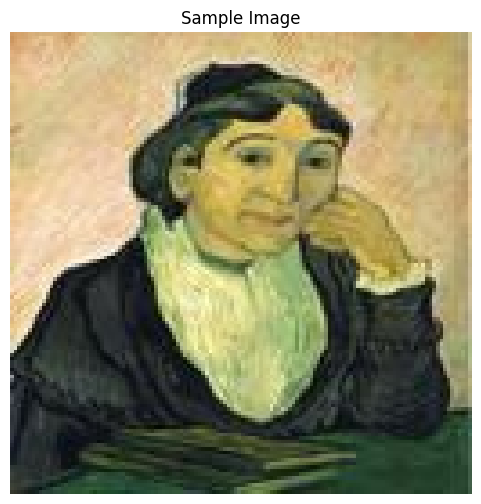

Ground Truth: She seems very happy in the picture, and you want to know what what is behind the smile.
BLIP Caption: a painting of a woman sitting at a table


In [8]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration

# ---------- Load BLIP ----------
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "Salesforce/blip-image-captioning-base"

processor = BlipProcessor.from_pretrained(model_name)
model = BlipForConditionalGeneration.from_pretrained(model_name).to(device)

# ---------- Load your CSV ----------
csv_path = r"C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\data\artemis_preprocessed_with_paths.csv"
df = pd.read_csv(csv_path)

# pick any sample
sample_path = df["img_resized_path"].iloc[0]
caption_txt = df["utterance"].iloc[0]  # optional: see the human caption

print("Using sample:", sample_path)

# ---------- Load and show image ----------
img = Image.open(sample_path).convert("RGB")

plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis("off")
plt.title("Sample Image")
plt.show()

# ---------- Run BLIP captioning ----------
inputs = processor(img, return_tensors="pt").to(device)
out = model.generate(**inputs)
blip_caption = processor.decode(out[0], skip_special_tokens=True)

print("Ground Truth:", caption_txt)
print("BLIP Caption:", blip_caption)


In [9]:
import pandas as pd

CSV_PATH = r"C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\data\artemis_preprocessed_with_paths.csv"
df = pd.read_csv(CSV_PATH)

print(df.columns)
df.head()


Index(['art_style', 'painting', 'emotion', 'utterance', 'repetition', 'split',
       'tokens', 'tokens_len', 'tokens_encoded', 'img_resized_path'],
      dtype='object')


,art_style,painting,emotion,utterance,repetition,split,tokens,tokens_len,tokens_encoded,img_resized_path
0,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,something else,"She seems very happy in the picture, and you w...",10,val,"['she', 'seems', 'very', 'happy', 'in', 'the',...",18,"[2, 18, 275, 146, 283, 14, 11, 3085, 7, 502, 5...",C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\i...
1,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,sadness,This woman has really knotty hands which makes...,10,val,"['this', 'woman', 'has', 'really', 'knotty', '...",14,"[2, 54, 212, 23, 131, 1, 161, 156, 49, 47, 32,...",C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\i...
2,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,something else,"When looking at this woman, I am filled with c...",10,val,"['when', 'looking', 'at', 'this', 'woman,', 'i...",27,"[2, 874, 293, 285, 54, 2364, 124, 315, 496, 93...",C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\i...
3,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,contentment,"A woman looking at ease, peaceful, and satisfi...",10,val,"['a', 'woman', 'looking', 'at', 'ease,', 'peac...",15,"[2, 57, 212, 293, 285, 6735, 1313, 7, 2873, 27...",C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\i...
4,Expressionism,wassily-kandinsky_study-for-autumn-1909,awe,The bright colors make a very unique scene for...,7,val,"['the', 'bright', 'colors', 'make', 'a', 'very...",12,"[2, 11, 183, 26, 80, 57, 146, 1732, 145, 169, ...",C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\i...


In [3]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset
from transformers import BlipProcessor, BlipForConditionalGeneration

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# ---- YOUR PROJECT ROOT ----
PROJECT_ROOT = r"C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject"

# ---- YOUR CSV PATHS ----
train_csv = rf"{PROJECT_ROOT}\data\train.csv"
val_csv   = rf"{PROJECT_ROOT}\data\val.csv"
test_csv  = rf"{PROJECT_ROOT}\data\test.csv"

# ---- Load BLIP (base) ----
model_name = "Salesforce/blip-image-captioning-base"
processor = BlipProcessor.from_pretrained(model_name)
model = BlipForConditionalGeneration.from_pretrained(model_name).to(device)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Device: cuda


'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /Salesforce/blip-image-captioning-base/resolve/main/preprocessor_config.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000204F2BDB0B0>: Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: 69859484-be3f-4d30-8f5b-40c70b1bc587)')' thrown while requesting HEAD https://huggingface.co/Salesforce/blip-image-captioning-base/resolve/main/preprocessor_config.json
Retrying in 1s [Retry 1/5].
'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /Salesforce/blip-image-captioning-base/resolve/main/preprocessor_config.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000204F2DB8F80>: Failed to resolve \'huggingface.co\' ([Errno 11002] getaddrinfo failed)"))'), '(Request ID: f6a0daf7-40d2-470b-afa5-e7cc9fd06996)')' thrown while reque

In [4]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

CSV_PATH = r"C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\data\artemis_preprocessed_with_paths.csv"
IMG_COL = "img_resized_path"
CAPTION_COL = "utterance"

class ArtEmisBlipDataset(Dataset):
    def __init__(self, csv_path, processor, img_col=IMG_COL, cap_col=CAPTION_COL, max_length=40):
        self.df = pd.read_csv(csv_path)
        self.img_paths = self.df[img_col].tolist()
        self.captions = self.df[cap_col].tolist()
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        caption = str(self.captions[idx])

        # make it absolute if paths in CSV are relative
        if not os.path.isabs(img_path):
            img_path = os.path.join(
                r"C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject",
                img_path
            )

        image = Image.open(img_path).convert("RGB")

        encoding = self.processor(
            images=image,
            text=caption,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )

        # BLIP uses labels == input_ids with PAD tokens masked as -100
        input_ids = encoding["input_ids"].squeeze(0)
        attention_mask = encoding["attention_mask"].squeeze(0)
        pixel_values = encoding["pixel_values"].squeeze(0)

        labels = input_ids.clone()
        labels[labels == self.processor.tokenizer.pad_token_id] = -100

        return {
            "pixel_values": pixel_values,
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
        }

dataset = ArtEmisBlipDataset(CSV_PATH, processor)

len(dataset), dataset[0]["pixel_values"].shape


(430767, torch.Size([3, 384, 384]))

In [34]:
train_dataset = ArtEmisBlipDataset(train_csv, processor)
val_dataset   = ArtEmisBlipDataset(val_csv, processor)
test_dataset  = ArtEmisBlipDataset(test_csv, processor)

print(len(train_dataset), len(val_dataset), len(test_dataset))


17000 1700 64319


Caption from CSV: Too much yellow and red and poorly blended, and the green used in the masks and on the faces clashes.


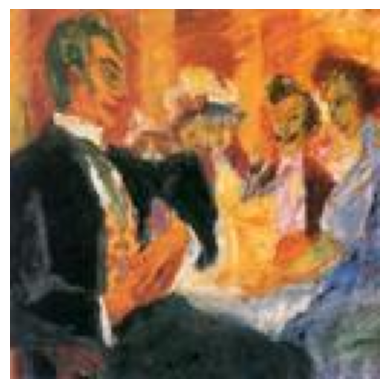

In [13]:
#Sanity check

import matplotlib.pyplot as plt

sample = train_dataset[0]
print("Caption from CSV:", train_dataset.captions[0])

# reconstruct image path and show it
first_img_path = train_dataset.img_paths[0]
if not os.path.isabs(first_img_path):
    first_img_path = os.path.join(PROJECT_ROOT, first_img_path)

img = Image.open(first_img_path).convert("RGB")
plt.imshow(img)
plt.axis("off")
plt.show()


In [19]:
from transformers import Trainer

class BlipTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        """
        Custom loss computation that does NOT forward num_items_in_batch to the model.
        We call the BLIP model explicitly with the right arguments.
        """
        # make a shallow copy so we don't mutate the original dict
        inputs = inputs.copy()

        labels = inputs.pop("labels")

        outputs = model(
            pixel_values=inputs["pixel_values"],
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            labels=labels,
        )

        loss = outputs.loss

        if return_outputs:
            return loss, outputs
        return loss


In [6]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"


In [55]:
from transformers import TrainingArguments, Trainer
from transformers import TrainingArguments
import torch

def collate_fn(batch):
    return {
        "pixel_values": torch.stack([b["pixel_values"] for b in batch]),
        "input_ids": torch.stack([b["input_ids"] for b in batch]),
        "attention_mask": torch.stack([b["attention_mask"] for b in batch]),
        "labels": torch.stack([b["labels"] for b in batch]),
    }

output_dir = rf"{PROJECT_ROOT}\blip_finetuned_artemis"

training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=1,                 # you can bump this later
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_steps=50,
    save_steps=500,
    save_total_limit=2,
    do_eval=True,
    fp16=(device == "cuda"),
    remove_unused_columns=False,
    report_to=[],
)


trainer = BlipTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn,
)

trainer.train()


Step,Training Loss
50,3.566900
100,3.617000
150,3.628300
200,3.701500
250,3.545700
300,3.697400
350,3.541100
400,3.745800
450,3.617800
500,3.669400


TrainOutput(global_step=4250, training_loss=3.4834753705193013, metrics={'train_runtime': 12352.6829, 'train_samples_per_second': 1.376, 'train_steps_per_second': 0.344, 'total_flos': 9.030443548409856e+18, 'train_loss': 3.4834753705193013, 'epoch': 1.0})

In [7]:
from transformers import BlipProcessor, BlipForConditionalGeneration, TrainingArguments, Trainer
import torch


In [49]:
#Small csv
import pandas as pd

train_csv = r"C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\data\train.csv"
val_csv   = r"C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\data\val.csv"

# Load full data
full_train_df = pd.read_csv(train_csv)
full_val_df   = pd.read_csv(val_csv)

print("Original train size:", len(full_train_df))
print("Original val size:", len(full_val_df))

# Subsample
train_df_small = full_train_df.sample(n=17000, random_state=42).reset_index(drop=True)
val_df_small   = full_val_df.sample(n=1700, random_state=42).reset_index(drop=True)

print("New train size:", len(train_df_small))
print("New val size:", len(val_df_small))

# Save new CSVs
train_small_csv = r"C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\data\train_small.csv"
val_small_csv   = r"C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\data\val_small.csv"

train_df_small.to_csv(train_small_csv, index=False)
val_df_small.to_csv(val_small_csv, index=False)


Original train size: 344581
Original val size: 21867
New train size: 17000
New val size: 1700


In [38]:
#build ds

train_csv = r"C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\data\train_small.csv"
val_csv   = r"C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\data\val_small.csv"

train_dataset = ArtEmisBlipDataset(train_csv, processor)
val_dataset   = ArtEmisBlipDataset(val_csv, processor)

print("Train len:", len(train_dataset))
print("Val len:", len(val_dataset))


Train len: 17000
Val len: 1700


In [56]:
# ---------- SAVE FINAL FINE-TUNED MODEL ----------
save_path = rf"{output_dir}\final_model"

trainer.save_model(save_path)       # saves model + tokenizer config
processor.save_pretrained(save_path)

print("Saved fine-tuned BLIP to:", save_path)


Saved fine-tuned BLIP to: C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\blip_finetuned_artemis\final_model


In [3]:
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

# ---- paths ----
PROJECT_ROOT = r"C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject"
MODEL_DIR    = rf"{PROJECT_ROOT}\blip_finetuned_artemis\final_model"  # where you saved earlier
TEST_CSV     = rf"{PROJECT_ROOT}\data\test.csv"                      # adjust if needed

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

processor = BlipProcessor.from_pretrained(MODEL_DIR)
model = BlipForConditionalGeneration.from_pretrained(MODEL_DIR).to(device)
model.eval()


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Device: cuda


BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-0

In [4]:
def generate_caption(image_path, max_length=40, num_beams=3):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_length=max_length,
            num_beams=num_beams
        )

    caption = processor.decode(output_ids[0], skip_special_tokens=True)
    return caption


In [5]:
# load test data
df_test = pd.read_csv(TEST_CSV)
print(df_test.columns)   # just to confirm column names


Index(['art_style', 'painting', 'emotion', 'utterance', 'repetition', 'split',
       'tokens', 'tokens_len', 'tokens_encoded', 'img_resized_path'],
      dtype='object')


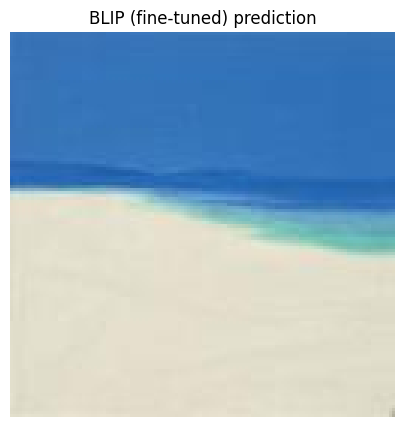

Image path   : C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\resized\wikiart_128\Contemporary_Realism\john-miller_beach(6).jpg
Ground truth : Very simple but this beach has nice uses of blues. The night sky is very still and calm which I enjoy.
Prediction   : the blue color of the sky and the white sand makes me feel like i ' m on vacation.
------------------------------------------------------------------------------------------


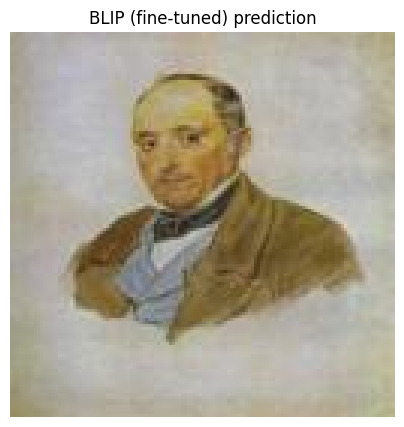

Image path   : C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\resized\wikiart_128\Romanticism\karl-bryullov_portrait-of-a-man-from-the-tittoni-s-family(1).jpg
Ground truth : The man's confident face and unkempt suit makes for a nice contrast.
Prediction   : the man ' s face looks like he ' s about to die. he looks like he ' s about to die.
------------------------------------------------------------------------------------------


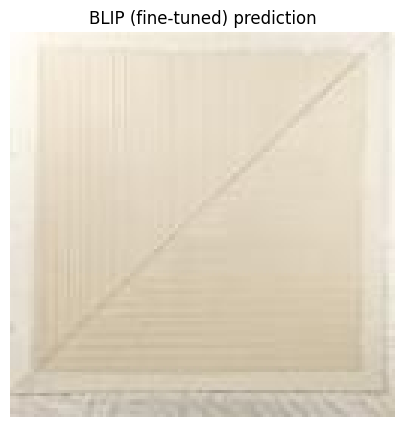

Image path   : C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\resized\wikiart_128\Minimalism\jean-degottex_pli-x-pli-iii.jpg
Ground truth : This almost looks like a pattern for a home design
Prediction   : it looks like a blank piece of paper on a table.
------------------------------------------------------------------------------------------


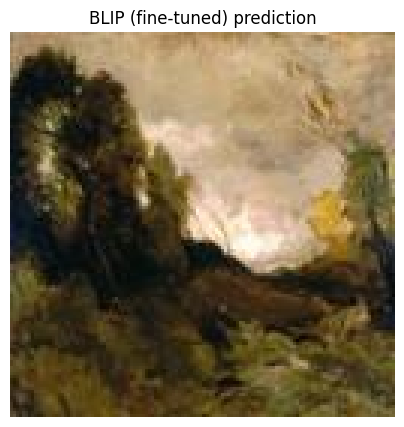

Image path   : C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\resized\wikiart_128\Realism\camille-corot_lonesome-valley-1874.jpg
Ground truth : It looks gloomy and window and like a long lonely journey ahead.
Prediction   : the clouds look like a storm is coming.
------------------------------------------------------------------------------------------


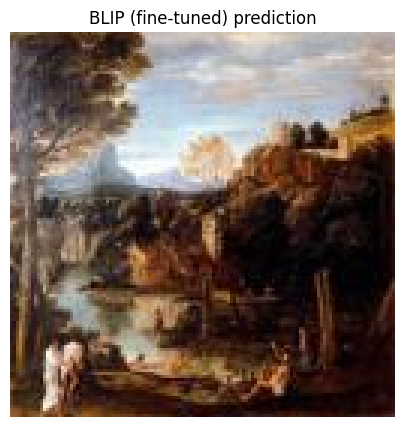

Image path   : C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\resized\wikiart_128\Baroque\annibale-carracci_not_detected_234546.jpg
Ground truth : Everyone looks so happy and carefree in this painting.
Prediction   : the people are having a good time by the water.
------------------------------------------------------------------------------------------


In [13]:
N_SAMPLES = 5   # change this to see more/less examples

sample = df_test.sample(N_SAMPLES)

for idx, row in sample.iterrows():
    img_path = row["img_resized_path"]          # change name if different
    gt_text  = row.get("utterance", "")         # safe lookup

    pred_text = generate_caption(img_path)

    img = Image.open(img_path).convert("RGB")

    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.axis("off")
    plt.title("BLIP (fine-tuned) prediction", fontsize=12)
    plt.show()

    print("Image path   :", img_path)
    print("Ground truth :", gt_text)
    print("Prediction   :", pred_text)
    print("-"*90)


In [11]:
import os
import torch
from transformers import (
    BlipForConditionalGeneration,
    BlipProcessor,
    TrainingArguments,
    Trainer,
)

print("Using device:", device)

def collate_fn(batch):
    return {
        "pixel_values": torch.stack([b["pixel_values"] for b in batch]),
        "input_ids": torch.stack([b["input_ids"] for b in batch]),
        "attention_mask": torch.stack([b["attention_mask"] for b in batch]),
        "labels": torch.stack([b["labels"] for b in batch]),
    }
# -------------------------------------------
# Custom Trainer to AVOID num_items_in_batch
# -------------------------------------------
class BlipTrainer(Trainer):
    # NOTE: include num_items_in_batch in the signature but IGNORE it
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        return (loss, outputs) if return_outputs else loss


# -------------------------------------------
# Load model from last checkpoint
# -------------------------------------------
checkpoint_path = rf"{PROJECT_ROOT}\blip_finetuned_artemis\checkpoint-5000"

model = BlipForConditionalGeneration.from_pretrained(checkpoint_path).to(device)

# Processor: you can just reuse the original BLIP processor
# (it doesn't change during training)
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")

# Directory where all training outputs for both epochs live
output_dir = rf"{PROJECT_ROOT}\blip_finetuned_artemis"

# -------------------------------------------
# Train for TOTAL 2 epochs (you already did 1)
# -------------------------------------------
training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=2,                # total epochs (so ~1 more from checkpoint)
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_steps=50,
    save_steps=500,
    save_total_limit=2,
    do_eval=True,
    fp16=(device == "cuda"),
    remove_unused_columns=False,
    report_to=[],                      # no wandb/tensorboard
)

trainer = BlipTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn,
)

# This will resume from checkpoint-5000 and finish epoch 1 + run epoch 2
trainer.train(resume_from_checkpoint=checkpoint_path)

# -------------------------------------------
# Save final model + processor for easy reuse
# -------------------------------------------
final_model_dir = rf"{PROJECT_ROOT}\blip_finetuned_artemis\final_model_epoch2"
os.makedirs(final_model_dir, exist_ok=True)

trainer.save_model(final_model_dir)        # saves model + config
processor.save_pretrained(final_model_dir) # saves tokenizer + image processor

print("Saved final model to:", final_model_dir)


Using device: cuda


There were missing keys in the checkpoint model loaded: ['text_decoder.cls.predictions.decoder.weight', 'text_decoder.cls.predictions.decoder.bias'].


Step,Training Loss
5050,2.653200
5100,2.571800
5150,2.591400
5200,2.693600
5250,2.640900
5300,2.585800
5350,2.554100
5400,2.593200
5450,2.567400
5500,2.570900


Saved final model to: C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\blip_finetuned_artemis\final_model_epoch2


Using device: cuda


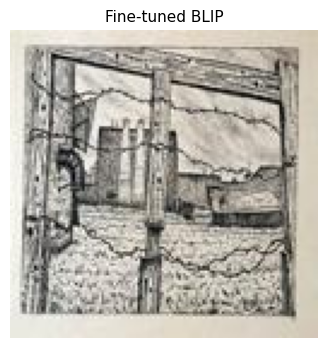

Image path   : C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\resized\wikiart_128\Expressionism\mstislav-dobuzhinsky_kitchen-garden-on-obvodny-channel-1921.jpg
Ground truth : The black and white color of the painting with the fence and the barb wire in the foreground makes me feel trapped and caged in.
Prediction   : the black and white coloring makes the scene look like a scary place.
--------------------------------------------------------------------------------


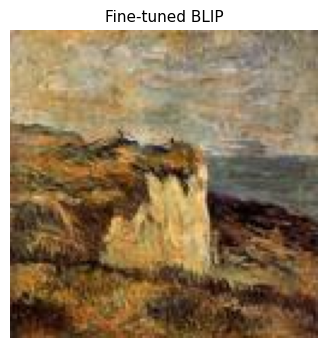

Image path   : C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\resized\wikiart_128\Impressionism\paul-gauguin_cliff-near-dieppe-1885.jpg
Ground truth : The texture of the cliff is set strongly against the texture of the winded plains.
Prediction   : the colors are very muted and the scene is very serene.
--------------------------------------------------------------------------------


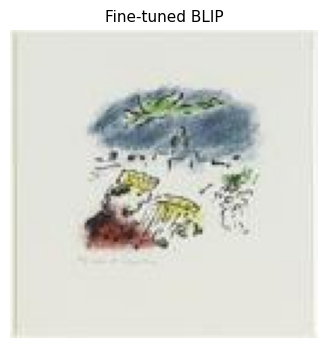

Image path   : C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\resized\wikiart_128\Naive_Art_Primitivism\marc-chagall_king-david-1973.jpg
Ground truth : this drawing reminds me of the red bull animated commercials
Prediction   : the colors are very calming and the scene is very peaceful.
--------------------------------------------------------------------------------


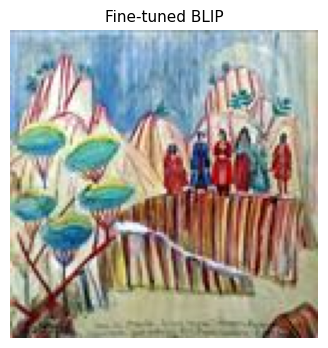

Image path   : C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\resized\wikiart_128\Expressionism\martiros-saryan_sketch-of-the-second-act-of-the-opera-by-rimsky-korsakov-s-golden-cockerel-1930.jpg
Ground truth : I feel one person is about to be pushed off the sharp cliffs
Prediction   : the colors are bright and happy and the people look like they are having a good time.
--------------------------------------------------------------------------------


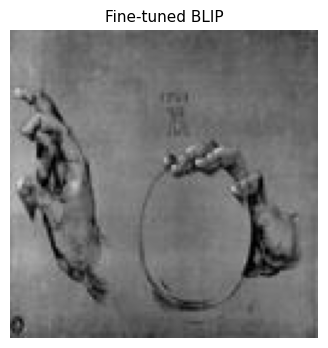

Image path   : C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\resized\wikiart_128\Northern_Renaissance\albrecht-durer_hand-of-god-the-father.jpg
Ground truth : The hand seems to be all-knowing since it has a firm grasp on the globe
Prediction   : the man ' s body is very detailed and his hand is very detailed.
--------------------------------------------------------------------------------


In [17]:
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

MODEL_DIR = r"C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\blip_finetuned_artemis\final_model_epoch2"

processor = BlipProcessor.from_pretrained(MODEL_DIR)
model = BlipForConditionalGeneration.from_pretrained(MODEL_DIR).to(device)
model.eval()

# -----------------------------
# 2. Helper: generate caption
# -----------------------------
def generate_caption(image_path, max_new_tokens=40):
    """
    Generate a caption with your fine-tuned BLIP model.
    """
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
        )

    caption = processor.decode(output_ids[0], skip_special_tokens=True)
    return caption.strip()


import pandas as pd
from matplotlib import pyplot as plt

CSV_TEST = r"C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\data\test.csv"

df_test = pd.read_csv(CSV_TEST)

N_SAMPLES = 5
sample = df_test.sample(N_SAMPLES, random_state=42)

for _, row in sample.iterrows():
    img_path = row["img_resized_path"]
    gt_text = row.get("utterance", "")

    pred_text = generate_caption(img_path)

    img = Image.open(img_path).convert("RGB")
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Fine-tuned BLIP", fontsize=11)
    plt.show()

    print("Image path   :", img_path)
    print("Ground truth :", gt_text)
    print("Prediction   :", pred_text)
    print("-"*80)


In [23]:
# ===================== Model 2: ViT-GPT2 =====================
import os
import torch
import pandas as pd
from PIL import Image
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import (
    VisionEncoderDecoderModel,
    AutoFeatureExtractor,
    AutoTokenizer,
)

# ---------------------------------------
# 1. Load your small CSVs as DATAFRAMES
# ---------------------------------------
train_csv_path = r"C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\data\train_small.csv"
val_csv_path   = r"C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\data\val_small.csv"

train_df = pd.read_csv(train_csv_path)
val_df   = pd.read_csv(val_csv_path)

IMG_COL = "img_resized_path"
CAP_COL = "utterance"

print("Train columns:", train_df.columns)
print("Train size:", len(train_df), "Val size:", len(val_df))

# ---------------------------------------
# 2. MODEL + TOKENIZER + FEATURE EXTRACTOR
# ---------------------------------------
model_name = "nlpconnect/vit-gpt2-image-captioning"

feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = VisionEncoderDecoderModel.from_pretrained(model_name)

model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.vocab_size = len(tokenizer)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
model.to(device)

# ---------------------------------------
# 3. DATASET CLASS
# ---------------------------------------
class ArtEmisViTDataset(Dataset):
    def __init__(self, df, feature_extractor, tokenizer,
                 img_col=IMG_COL, cap_col=CAP_COL, max_length=40):
        self.df = df.reset_index(drop=True)
        self.feature_extractor = feature_extractor
        self.tokenizer = tokenizer
        self.img_col = img_col
        self.cap_col = cap_col
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_path = row[self.img_col]
        caption  = str(row[self.cap_col])

        # image -> pixel_values
        image = Image.open(img_path).convert("RGB")
        pixel_values = self.feature_extractor(
            images=image, return_tensors="pt"
        ).pixel_values.squeeze(0)   # (3, H, W)

        # text -> input_ids
        enc = self.tokenizer(
            caption,
            padding="max_length",
            max_length=self.max_length,
            truncation=True,
            return_tensors="pt",
        )
        input_ids = enc["input_ids"].squeeze(0)

        labels = input_ids.clone()
        labels[labels == tokenizer.pad_token_id] = -100

        return {
            "pixel_values": pixel_values,
            "labels": labels,
        }

# build datasets + loaders
train_ds = ArtEmisViTDataset(train_df, feature_extractor, tokenizer)
val_ds   = ArtEmisViTDataset(val_df,   feature_extractor, tokenizer)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False)


Train columns: Index(['art_style', 'painting', 'emotion', 'utterance', 'repetition', 'split',
       'tokens', 'tokens_len', 'tokens_encoded', 'img_resized_path'],
      dtype='object')
Train size: 17000 Val size: 1700


'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /nlpconnect/vit-gpt2-image-captioning/resolve/main/preprocessor_config.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000204F2BDA840>: Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: 7b491899-3cc9-4b43-b89d-4d28695cb8e6)')' thrown while requesting HEAD https://huggingface.co/nlpconnect/vit-gpt2-image-captioning/resolve/main/preprocessor_config.json
Retrying in 1s [Retry 1/5].


preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

C:\Users\yuvra\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\yuvra\.cache\huggingface\hub\models--nlpconnect--vit-gpt2-image-captioning. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
C:\Users\yuvra\anaconda3\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:30: FutureWarn

tokenizer_config.json:   0%|          | 0.00/241 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

Using device: cuda


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/982M [00:00<?, ?B/s]

In [26]:
import warnings
warnings.filterwarnings("ignore")   # hide padding/mask warnings

epochs = 2
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)

    for batch in pbar:
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item()
        pbar.set_postfix(loss=float(loss))

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}: avg train loss = {avg_loss:.4f}")


Epoch 1/2: 100%|██████████████████████████████████████████████████████| 2125/2125 [1:04:30<00:00,  1.82s/it, loss=5.44]


Epoch 1: avg train loss = 5.3018


Epoch 2/2: 100%|██████████████████████████████████████████████████████| 2125/2125 [1:03:52<00:00,  1.80s/it, loss=4.23]

Epoch 2: avg train loss = 4.7640


In [27]:
save_dir = rf"{PROJECT_ROOT}\vit_gpt2_artemis_small"
os.makedirs(save_dir, exist_ok=True)

model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)
feature_extractor.save_pretrained(save_dir)

print("Saved ViT-GPT2 model to:", save_dir)

Saved ViT-GPT2 model to: C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\vit_gpt2_artemis_small


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


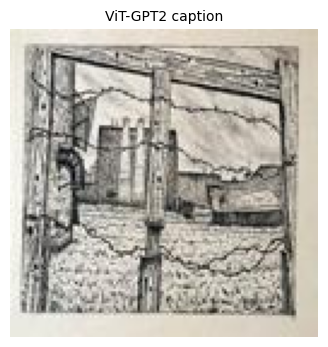

Image path   : C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\resized\wikiart_128\Expressionism\mstislav-dobuzhinsky_kitchen-garden-on-obvodny-channel-1921.jpg
Ground truth : The black and white color of the painting with the fence and the barb wire in the foreground makes me feel trapped and caged in.
Prediction   :  looks it a of old, old, old, old, old, old, old, old, old, old, old, old, old, old, old, old, old, old
--------------------------------------------------------------------------------


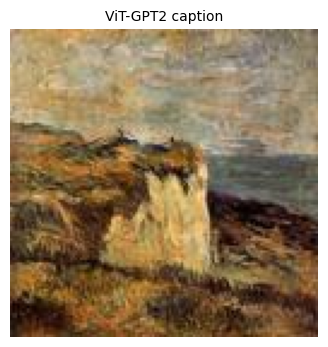

Image path   : C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\resized\wikiart_128\Impressionism\paul-gauguin_cliff-near-dieppe-1885.jpg
Ground truth : The texture of the cliff is set strongly against the texture of the winded plains.
Prediction   :  looks a of ocean the is beautiful the looks the is the of ocean the is beautiful the looks the is the of ocean the is beautiful the looks the is the of ocean the is beautiful the is
--------------------------------------------------------------------------------


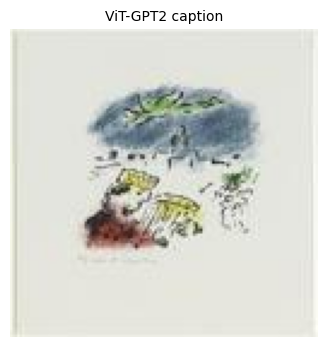

Image path   : C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\resized\wikiart_128\Naive_Art_Primitivism\marc-chagall_king-david-1973.jpg
Ground truth : this drawing reminds me of the red bull animated commercials
Prediction   :  colors the are and shapes the are. looks a of and a of. looks a of and a of. looks a of and a of. looks a of and a of. looks a of
--------------------------------------------------------------------------------


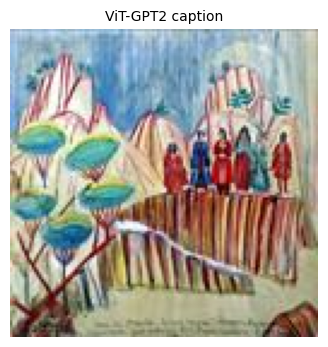

Image path   : C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\resized\wikiart_128\Expressionism\martiros-saryan_sketch-of-the-second-act-of-the-opera-by-rimsky-korsakov-s-golden-cockerel-1930.jpg
Ground truth : I feel one person is about to be pushed off the sharp cliffs
Prediction   :  shapes shapes shapes shapes shapes shapes shapes shapes shapes shapes shapes shapes shapes shapes shapes shapes shapes shapes shapes shapes shapes shapes shapes shapes shapes shapes shapes shapes shapes shapes shapes shapes shapes shapes shapes shapes shapes shapes shapes
--------------------------------------------------------------------------------


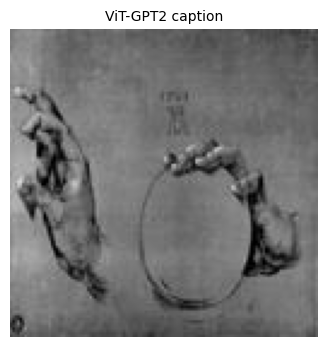

Image path   : C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\resized\wikiart_128\Northern_Renaissance\albrecht-durer_hand-of-god-the-father.jpg
Ground truth : The hand seems to be all-knowing since it has a firm grasp on the globe
Prediction   :  looks a of and a of. looks a of and a of. looks a of and a of. looks a of and a of. looks a of and a of. looks a of.
--------------------------------------------------------------------------------


In [28]:
from matplotlib import pyplot as plt

def generate_caption_vit(image_path, max_length=40, num_beams=3):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    pixel_values = feature_extractor(
        images=image, return_tensors="pt"
    ).pixel_values.to(device)

    with torch.no_grad():
        output_ids = model.generate(
            pixel_values,
            max_length=max_length,
            num_beams=num_beams,
            early_stopping=True,
        )

    caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return caption

# Example: run on a few test images from your df_test / df_small_test
N_SAMPLES = 5
sample = df_test.sample(N_SAMPLES, random_state=42)

for _, row in sample.iterrows():
    img_path = row[IMG_COL]
    gt_text  = row.get(CAP_COL, "")

    pred = generate_caption_vit(img_path)

    img = Image.open(img_path).convert("RGB")
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis("off")
    plt.title("ViT-GPT2 caption", fontsize=10)
    plt.show()

    print("Image path   :", img_path)
    print("Ground truth :", gt_text)
    print("Prediction   :", pred)
    print("-"*80)


In [44]:
#Retraining the model cuh

# ================================
# Model 2: ViT-GPT2 Image Captioning (ArtEmis)
# ================================
import os
import torch
import pandas as pd
from PIL import Image
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import (
    VisionEncoderDecoderModel,
    AutoFeatureExtractor,
    AutoTokenizer,
)

# -------------------------
# 1. Paths & DataFrames
# -------------------------
train_csv_path = r"C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\data\train_small.csv"
val_csv_path   = r"C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\data\val_small.csv"
test_csv_path  = r"C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\data\test_small.csv"

IMG_COL = "img_resized_path"
CAP_COL = "utterance"   # emotional caption column

df_train = pd.read_csv(train_csv_path)
df_val   = pd.read_csv(val_csv_path)
df_test  = pd.read_csv(test_csv_path)

print("Train/Val/Test sizes:", len(df_train), len(df_val), len(df_test))
print("Columns:", df_train.columns.tolist())

# -------------------------
# 2. Model + Tokenizer
# -------------------------
model_name = "nlpconnect/vit-gpt2-image-captioning"

feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# --- IMPORTANT: give GPT-2 a real pad token ---
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({"pad_token": "[PAD]"})
    print("Added new pad token:", tokenizer.pad_token)

model = VisionEncoderDecoderModel.from_pretrained(model_name)

# because we may have changed vocab size
model.resize_token_embeddings(len(tokenizer))

model.config.eos_token_id = tokenizer.eos_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.vocab_size = len(tokenizer)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
model.to(device)

# -------------------------
# 3. Dataset
# -------------------------
class ArtEmisViTDataset(Dataset):
    def __init__(self, df, feature_extractor, tokenizer,
                 img_col=IMG_COL, cap_col=CAP_COL, max_length=64):
        self.df = df.reset_index(drop=True)
        self.feature_extractor = feature_extractor
        self.tokenizer = tokenizer
        self.img_col = img_col
        self.cap_col = cap_col
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row[self.img_col]
        caption  = str(row[self.cap_col])

        # ----- image -> pixel values -----
        image = Image.open(img_path).convert("RGB")
        pixel_values = self.feature_extractor(
            images=image,
            return_tensors="pt"
        ).pixel_values.squeeze(0)  # (3, H, W)

        # ----- text -> ids + attention mask -----
        enc = self.tokenizer(
            caption,
            padding="max_length",
            max_length=self.max_length,
            truncation=True,
            return_tensors="pt",
        )
        input_ids = enc["input_ids"].squeeze(0)         # (L,)
        attention_mask = enc["attention_mask"].squeeze(0)

        # labels: ignore padding when computing loss
        labels = input_ids.clone()
        labels[labels == self.tokenizer.pad_token_id] = -100

        return {
            "pixel_values": pixel_values,
            "labels": labels,
            "decoder_attention_mask": attention_mask,
        }

train_ds = ArtEmisViTDataset(df_train, feature_extractor, tokenizer)
val_ds   = ArtEmisViTDataset(df_val,   feature_extractor, tokenizer)

def collate_fn(batch):
    pixel_values = torch.stack([b["pixel_values"] for b in batch])
    labels = torch.stack([b["labels"] for b in batch])
    decoder_attention_mask = torch.stack([b["decoder_attention_mask"] for b in batch])
    return {
        "pixel_values": pixel_values,
        "labels": labels,
        "decoder_attention_mask": decoder_attention_mask,
    }

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False, collate_fn=collate_fn)

# -------------------------
# 4. Training Loop
# -------------------------
epochs = 2                 # you can tweak this
lr     = 5e-5

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

for epoch in range(epochs):
    # ----- TRAIN -----
    model.train()
    total_train_loss = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [train]")
    for batch in pbar:
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)
        decoder_attention_mask = batch["decoder_attention_mask"].to(device)

        optimizer.zero_grad()

        outputs = model(
            pixel_values=pixel_values,
            labels=labels,
            decoder_attention_mask=decoder_attention_mask,
        )
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_train_loss += loss.item()
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    avg_train_loss = total_train_loss / len(train_loader)

    # ----- VALIDATION (optional but nice) -----
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)
            decoder_attention_mask = batch["decoder_attention_mask"].to(device)

            outputs = model(
                pixel_values=pixel_values,
                labels=labels,
                decoder_attention_mask=decoder_attention_mask,
            )
            loss = outputs.loss
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    print(f"\nEpoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}\n")

# -------------------------
# 5. Save final model
# -------------------------
final_dir = r"C:\Users\yuvra\OneDrive\Desktop\Monsoon 2025\iml_assignments\A3\ArtEmisProject\vit_gpt2_artemis_final"
os.makedirs(final_dir, exist_ok=True)
model.save_pretrained(final_dir)
feature_extractor.save_pretrained(final_dir)
tokenizer.save_pretrained(final_dir)
print("Saved final ViT-GPT2 model to:", final_dir)

# -------------------------
# 6. Inference helper
# -------------------------
def generate_caption(image_path, max_length=64, num_beams=3):
    model.eval()
    img = Image.open(image_path).convert("RGB")
    pixel_values = feature_extractor(images=img, return_tensors="pt").pixel_values.to(device)

    with torch.no_grad():
        output_ids = model.generate(
            pixel_values,
            max_length=max_length,
            num_beams=num_beams,
            repetition_penalty=1.2,  # helps a bit with "old old old" loops
        )
    caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return caption

# quick sanity check on a few random test images
import random
from matplotlib import pyplot as plt

sample = df_test.sample(3, random_state=42)
for _, row in sample.iterrows():
    img_path = row[IMG_COL]
    gt = row[CAP_COL]
    pred = generate_caption(img_path)

    img = Image.open(img_path).convert("RGB")
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

    print("Image path  :", img_path)
    print("Ground truth:", gt)
    print("Prediction  :", pred)
    print("-"*120)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\yuvra\\OneDrive\\Desktop\\Monsoon 2025\\iml_assignments\\A3\\ArtEmisProject\\data\\test_small.csv'